In [77]:
import pandas as pd
import sys
import sqlalchemy
import os


%matplotlib inline

CONN = sqlalchemy.create_engine('sqlite:///data.db')


#CONN.execute('PRAGMA table_info(player_stats)').fetchall()
#CONN.execute(sqlalchemy.text('SELECT player_id, full_name from player_stats where player_id = :p'),p=101106).fetchone()


In [78]:
os.listdir('../Sports')

['.DS_Store', 'Baseball', 'Basketball', 'E-Sports', 'Football', 'Soccer']

In [104]:
nba_data_path = '../Sports/Basketball/Nba Data.csv'
players_path = '../Sports/Basketball/Players.csv'
season_stats = '../Sports/Basketball/Seasons_Stats.csv'

nba_df = pd.read_csv(nba_data_path)
players_df = pd.read_csv(players_path)
season_stats_df = pd.read_csv(season_stats)


player_percentages = nba_df[list([column for column in nba_df.columns if ('Percentage' in column and 'Rebound' not in column and 'Effective' not in column and 'Against' not in column) or column == 'Name'])]

player_percentages.to_sql('player_percentages',CONN,if_exists='replace')
players_df.to_sql('player',CONN, if_exists='replace')


players_df.columns = ['id','name','height','weight','college','born','birth_city','birth_state']

columns = list(season_stats_df.columns)
columns[0] = 'id'
season_stats_df.columns = columns


duplicate_players_total = nba_df[(nba_df.duplicated(subset=['Full Name'])) & (nba_df['Team'] == 'TOTAL')]

nba_df = nba_df.drop_duplicates(subset=['Full Name'], keep=False)

nba_player_stats_df = pd.concat([nba_df, duplicate_players_total])

nba_player_stats_cols = list(nba_player_stats_df.columns)
nba_player_stats_cols[32] = 'Second Pass Hockey Assist'
nba_player_stats_cols = ['_'.join(column.strip().lower().split())  for column in nba_player_stats_cols]

nba_player_stats_df.columns = nba_player_stats_cols


nba_player_stats_df.team = nba_player_stats_df.team.apply(lambda x : x.lower())


nbapstatsdfkmeans = nba_player_stats_df[['player_id',
 'pull_up_field_goals_attempted_per_game',
 'pull_up_3_point_field_goals_attempted_per_game',
 'catch_and_shoot_field_goal_attempted_per_game',
 'catch_and_shoot_3_point_attempts_per_game',
 'field_goal_attempted_drive',
 'field_goal_attempted_close_range',
 'field_goal_attempted_catch_and_shoot',
 'field_goal_attempted_pull_up']]




In [107]:
# Solving null values problem in df. 
nbapstatsdfkmeans =  nbapstatsdfkmeans.fillna(value=0.0)
nbapstatsdfkmeans


,player_id,pull_up_field_goals_attempted_per_game,pull_up_3_point_field_goals_attempted_per_game,catch_and_shoot_field_goal_attempted_per_game,catch_and_shoot_3_point_attempts_per_game,field_goal_attempted_drive,field_goal_attempted_close_range,field_goal_attempted_catch_and_shoot,field_goal_attempted_pull_up
0,101106,0.181818,0.000000,0.121212,0.000000,0.378788,1.500000,0.121212,0.181818
1,101107,0.803030,0.242424,4.515152,3.257576,0.848485,0.424242,4.515152,0.803030
2,101108,8.435484,2.129032,1.467742,1.096774,2.532258,0.387097,1.467742,8.435484
3,101109,3.338462,1.015385,2.615385,1.969231,2.384615,0.261538,2.615385,3.338462
4,101110,1.272727,0.441558,4.714286,4.259740,0.415584,0.337662,4.714286,1.272727
5,101111,0.500000,0.300000,2.800000,2.500000,0.450000,0.400000,2.800000,0.500000
6,101112,0.817073,0.158537,6.182927,4.987805,0.304878,0.560976,6.182927,0.817073
7,101114,4.375000,1.546875,3.171875,2.546875,2.421875,0.328125,3.171875,4.375000
14,101123,4.317073,1.646341,5.256098,4.451220,1.146341,0.231707,5.256098,4.317073
15,101126,3.795455,1.568182,2.068182,1.840909,1.681818,0.159091,2.068182,3.795455


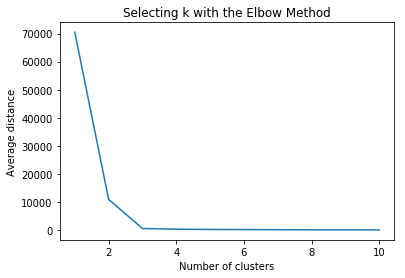

In [112]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import collections
import numpy as np
import matplotlib.pylab as plt


name_lookup = {record['player_id']:record['full_name'] for record in nba_player_stats_df[['player_id','full_name']].to_dict('records')}


clusters=range(1,11)
meandist = []

for k in clusters:
    train_set = nbapstatsdfkmeans
    model = KMeans(n_clusters=k)
    model.fit(train_set)
    model.predict(train_set)
    meandist.append(sum(np.min(cdist(train_set, model.cluster_centers_, 'euclidean'), axis=1)) / train_set.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')


# for cluster in clustering:
#     print("Cluster: %d"%(cluster))
#     player_cluster = nbapstatsdfkmeans[nbapstatsdfkmeans.index.isin(clustering[cluster])][['player_id']]
#     player_cluster.name = player_cluster.player_id.apply(lambda x : name_lookup[x])
#     print(player_cluster.name)
    
